<a href="https://colab.research.google.com/github/figonrit/Proyectos/blob/main/Taller_2_Fabi%C3%A1n_Gonz%C3%A1lez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Informe 1 Pre-procesamiento
# Fabián González Ritchie
# Diplomado Advanced Analytics
# Universidad de Chile 2021




En el siguiente análisis se estudiarán las variables correspondientes a clientes de un banco, los cuales presentan una serie de características, siendo la relevante para esta investigación si se termina fugando o no.


Para partir se descargan las librerias a utilizar:

In [ ]:
!pip -q install numpy gensim scikit-learn

Luego se importan las librerias a trabajar

In [ ]:
import pandas as pd
import numpy as np
import pandas.util.testing as tm
import matplotlib.pyplot as plt
import seaborn as sn

from pandas.api.types import is_numeric_dtype
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split

#librerias para modelos de clasificacion
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import statsmodels.api as srm

#para graficar el arbol de decision
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
from pydot import graph_from_dot_data

#librerias para la validacion y obtener metricas
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,roc_curve, auc,r2_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_validate

#guardar modelos entrenados
from joblib import dump, load
import os



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Primero se sube un archivo de google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Una vez cargado nuestro drive se carga el archivo a utilizar

In [ ]:
ruta_data_set = 'gdrive/My Drive/Colab Notebooks/BASEFUGA2021_F.xls'
data_set = pd.read_excel(ruta_data_set)

Descripcion de variables de la base de datos:

1.   ID: identificador del cliente.
2.   Genero: Género del cliente.
3.   Edad: Edad en años
4.   NIV_Educ: Nivel educacional.
5.   E_Civil: Estado civil.
6.   Ciudad: Ciudad de la oficina
7.   D_Marzo: Deuda de Marzo
8.   D_Abril: Deuda de Abril
9.   D_Mayo: Deuda de Mayo
10.  D_Junio: Deuda de Junio
11.  D_Julio: Deuda de Julio
12.  D_Agosto: Deuda de Agosto
13.  D_Septiembre: Deuda de Septiembre
14.  M_Moroso: Meses en Mora
15.  Monto: Monto preaprobado.
16.  Seguro: Seguro de gravamen.
17.  Fuga: Variable objetivo


# Análisis Exploratorio de Datos

## Estadística descriptiva

Para analizar el comportamiento de los datos de las variables numéricas, se calcula la media, desviación estandar, mínimo, máximo y cuartiles.

Mientras que para las variables categóricas se obtiene la cantidad de categorías de la variable (unique), la moda (top) y la frecuencia de de la moda (freq).

In [ ]:
data_set.describe(include='all')

,ID,GENERO,EDAD,NIV_EDUC,E_CIVIL,CIUDAD,D_Marzo,D_Abril,D_Mayo,D_Junio,D_Julio,D_Agosto,D_Septiembre,M_MOROSO,MONTO,SEGURO,FUGA
count,2294.000000,2283,2292.000000,2281,2282,2290,2.293000e+03,2.293000e+03,2.294000e+03,2.294000e+03,2293.000000,2293.000000,2294.000000,2292.000000,2.293000e+03,2294,2294
unique,NaN,2,NaN,5,4,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
top,NaN,M,NaN,UNV,CAS,SANTIAGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,NOFUGA
freq,NaN,1385,NaN,946,1429,1389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1816,1157
mean,1147.500000,NaN,43.551920,NaN,NaN,NaN,1.530874e+05,2.726998e+05,1.032315e+05,1.899761e+05,567.093328,3580.321413,1940.639494,1.250436,3.477824e+06,NaN,NaN
std,662.365081,NaN,8.875511,NaN,NaN,NaN,4.982859e+05,4.024124e+05,8.706984e+05,6.705042e+05,1075.500117,8944.021261,9868.816840,0.752197,2.293166e+06,NaN,NaN
min,1.000000,NaN,-50.000000,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,5.000000e+05,NaN,NaN
25%,574.250000,NaN,39.000000,NaN,NaN,NaN,0.000000e+00,1.759600e+04,0.000000e+00,0.000000e+00,7.000000,0.000000,0.000000,1.000000,1.700000e+06,NaN,NaN
50%,1147.500000,NaN,44.000000,NaN,NaN,NaN,0.000000e+00,1.341700e+05,0.000000e+00,5.502000e+03,146.000000,0.000000,56.000000,1.000000,2.600000e+06,NaN,NaN
75%,1720.750000,NaN,50.000000,NaN,NaN,NaN,0.000000e+00,3.745150e+05,0.000000e+00,1.749060e+05,630.000000,1493.000000,497.250000,2.000000,4.800000e+06,NaN,NaN


Se observa que existen algunas variables con datos inconsistentes, como "Edad", que posee un valor mínimo de -50 y máximo de 130.

In [ ]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2294 entries, 0 to 2293
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            2294 non-null   int64  
 1   GENERO        2283 non-null   object 
 2   EDAD          2292 non-null   float64
 3   NIV_EDUC      2281 non-null   object 
 4   E_CIVIL       2282 non-null   object 
 5   CIUDAD        2290 non-null   object 
 6   D_Marzo       2293 non-null   float64
 7   D_Abril       2293 non-null   float64
 8   D_Mayo        2294 non-null   int64  
 9   D_Junio       2294 non-null   int64  
 10  D_Julio       2293 non-null   float64
 11  D_Agosto      2293 non-null   float64
 12  D_Septiembre  2294 non-null   int64  
 13  M_MOROSO      2292 non-null   float64
 14  MONTO         2293 non-null   float64
 15  SEGURO        2294 non-null   object 
 16  FUGA          2294 non-null   object 
dtypes: float64(7), int64(4), object(6)
memory usage: 304.8+ KB


De los códigos utilizados anteriormente, se puede inferir que son datos para 2294 clientes, dado que describe() indica que no existen valores únicos en "ID" (en otras palabras, son todos distintos y no se repite ninguno). En el caso de info(), se observa que hay columnas con menor cantidad de datos, por lo que se puede concluir que existen clientes a los que les falta información.


La cantidad de valores perdidos se observa en el siguiente código:

In [ ]:
data_set.isnull().sum()

ID               0
GENERO          11
EDAD             2
NIV_EDUC        13
E_CIVIL         12
CIUDAD           4
D_Marzo          1
D_Abril          1
D_Mayo           0
D_Junio          0
D_Julio          1
D_Agosto         1
D_Septiembre     0
M_MOROSO         2
MONTO            1
SEGURO           0
FUGA             0
dtype: int64

## Gráficos

De manera de visualizar de mejor forma la variable 'EDAD', se realiza el siguiente gráfico:

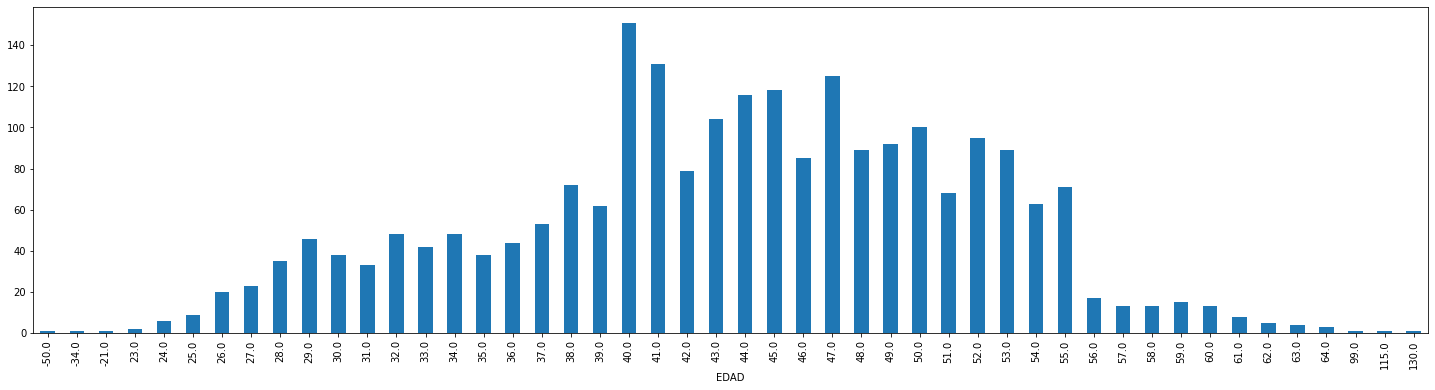

In [ ]:
data_set['EDAD'].value_counts().sort_index().plot.bar(figsize=(25,6))
plt.xlabel('EDAD')
plt.show()

En el gráfico anterior se puede observar que existe una gran cantidad de clientes entre 40 y 47 años, reduciéndose sostenidamente hasta los 55. Luego se produce una reducción drástica en la cantidad de clientes con edad igual o superior a los 56 años.

Además, en este gráfico se logra visualizar de mejor forma los valores inconsistentes, que son aquellos clientes iguales o superiores a 99 años y los que poseen edad negativa.

A continuación, se presenta un histograma de puntos para visualizar valores atípicos (outliers), para las deudas de cada mes:

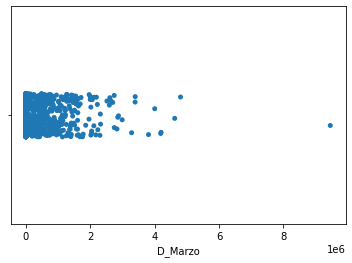

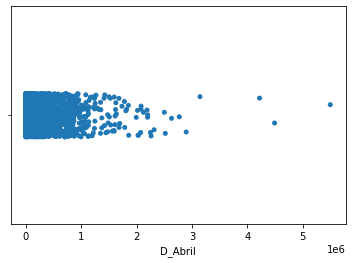

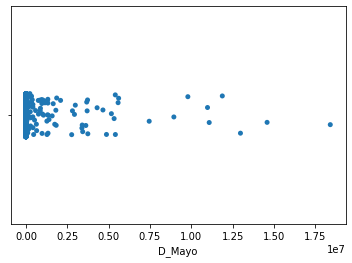

In [ ]:
sn.stripplot(x='D_Marzo', data=data_set)
plt.show()

sn.stripplot(x='D_Abril', data=data_set)
plt.show()

sn.stripplot(x='D_Mayo', data=data_set)
plt.show()



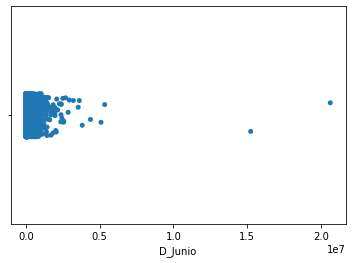

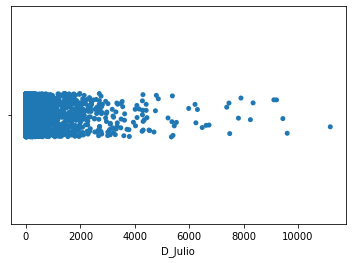

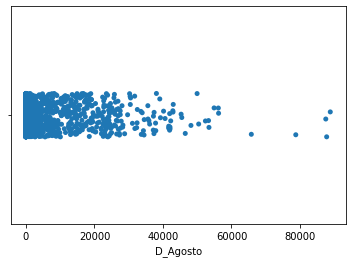

In [ ]:
sn.stripplot(x='D_Junio', data=data_set)
plt.show()

sn.stripplot(x='D_Julio', data=data_set)
plt.show()

sn.stripplot(x='D_Agosto', data=data_set)
plt.show()


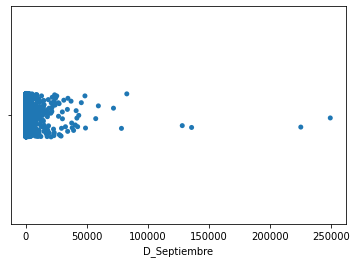

In [ ]:
sn.stripplot(x='D_Septiembre', data=data_set)
plt.show()

Se observa de manera preliminar que hay una alta concentración de datos en torno a cero, en otras palabras, no existe deudas o esta es muy baja para una amplia cantidad de datos.

A continuación se visualiza la relación existente entre la variable 'GENERO' y la variable objetivo ('FUGA')

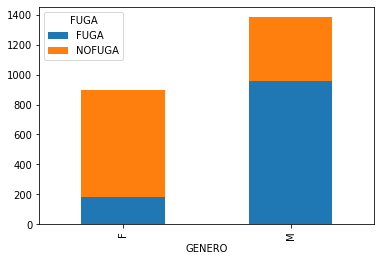

In [ ]:
data_set.groupby(['GENERO', 'FUGA']).size().unstack().plot.bar(stacked=True)
plt.show()

Del gráfico anterior, se puede desprender que existe una notoria superioridad del genero masculino en cantidad de fugas, siendo además superior la proporción de clientes hombres que se fugan con respecto a los que no, caso contrario a lo que ocurre con el genero femenino, que existe una menor cantidad y proporción de clientes que se fugan.

De manera adicional, en el siguiente gráfico se relaciona la variable objetivo con 'NIV_EDUC', presentándose una mayor proporción de clientes fugados para 'UNIV', mientras que 'EUN' presenta en su totalidad clientes no fugados.

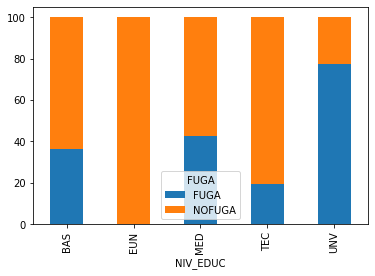

In [ ]:
data_set.groupby(['NIV_EDUC', 'FUGA']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot.bar(stacked=True)
plt.show()

A continuación se observa a escala real la diferencia de datos existentes para cada categoría de 'NIV_EDUC'.

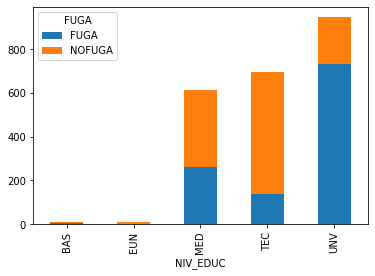

In [ ]:
data_set.groupby(['NIV_EDUC', 'FUGA']).size().unstack().plot.bar(stacked=True)
plt.show()

Como se puede observar, son muy pocos datos para 'BAS' y 'EUN'. En el caso de este último, al detectarse además que se trata solamente de clientes no fugados, se considerará como inconsistencia.

# Limpieza de datos

## Inconsistencias

Quedarán declaradas como nulas las inconsistencias detectadas anteriormente para 'EDAD' y 'NIV_EDUC':

In [ ]:
data_set.loc[data_set['EDAD'] < 0, ['EDAD']] = np.nan
data_set.loc[data_set['EDAD'] > 95, ['EDAD']] = np.nan
data_set.loc[data_set['NIV_EDUC'] == 'EUN', ['NIV_EDUC']] = np.nan

data_set.describe(include='all')

,ID,GENERO,EDAD,NIV_EDUC,E_CIVIL,CIUDAD,D_Marzo,D_Abril,D_Mayo,D_Junio,D_Julio,D_Agosto,D_Septiembre,M_MOROSO,MONTO,SEGURO,FUGA
count,2294.000000,2283,2286.000000,2269,2282,2290,2.293000e+03,2.293000e+03,2.294000e+03,2.294000e+03,2293.000000,2293.000000,2294.000000,2292.000000,2.293000e+03,2294,2294
unique,NaN,2,NaN,4,4,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
top,NaN,M,NaN,UNV,CAS,SANTIAGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,NOFUGA
freq,NaN,1385,NaN,946,1429,1389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1816,1157
mean,1147.500000,NaN,43.561680,NaN,NaN,NaN,1.530874e+05,2.726998e+05,1.032315e+05,1.899761e+05,567.093328,3580.321413,1940.639494,1.250436,3.477824e+06,NaN,NaN
std,662.365081,NaN,7.990333,NaN,NaN,NaN,4.982859e+05,4.024124e+05,8.706984e+05,6.705042e+05,1075.500117,8944.021261,9868.816840,0.752197,2.293166e+06,NaN,NaN
min,1.000000,NaN,23.000000,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,5.000000e+05,NaN,NaN
25%,574.250000,NaN,39.000000,NaN,NaN,NaN,0.000000e+00,1.759600e+04,0.000000e+00,0.000000e+00,7.000000,0.000000,0.000000,1.000000,1.700000e+06,NaN,NaN
50%,1147.500000,NaN,44.000000,NaN,NaN,NaN,0.000000e+00,1.341700e+05,0.000000e+00,5.502000e+03,146.000000,0.000000,56.000000,1.000000,2.600000e+06,NaN,NaN
75%,1720.750000,NaN,50.000000,NaN,NaN,NaN,0.000000e+00,3.745150e+05,0.000000e+00,1.749060e+05,630.000000,1493.000000,497.250000,2.000000,4.800000e+06,NaN,NaN


A continuación se observan la cantidad de datos nulos y su proporción con respecto al total de datos de la columna:

In [ ]:
data_set.isnull().sum()

ID               0
GENERO          11
EDAD             8
NIV_EDUC        25
E_CIVIL         12
CIUDAD           4
D_Marzo          1
D_Abril          1
D_Mayo           0
D_Junio          0
D_Julio          1
D_Agosto         1
D_Septiembre     0
M_MOROSO         2
MONTO            1
SEGURO           0
FUGA             0
dtype: int64

In [ ]:
print('EDAD: ' + str(round((data_set["EDAD"].isnull().sum()/data_set.shape[0]), 4)))
print('GENERO: ' + str(round((data_set["GENERO"].isnull().sum()/data_set.shape[0]), 4)))
print('NIV_EDUC: ' + str(round((data_set["NIV_EDUC"].isnull().sum()/data_set.shape[0]), 4)))
print('E_CIVIL: ' + str(round((data_set["E_CIVIL"].isnull().sum()/data_set.shape[0]), 4)))
print('CIUDAD: ' + str(round((data_set["CIUDAD"].isnull().sum()/data_set.shape[0]), 4)))
print('D_Marzo: ' + str(round((data_set["D_Marzo"].isnull().sum()/data_set.shape[0]), 4)))
print('D_Abril: ' + str(round((data_set["D_Abril"].isnull().sum()/data_set.shape[0]), 4)))
print('D_Julio: ' + str(round((data_set["D_Julio"].isnull().sum()/data_set.shape[0]), 4)))
print('D_Agosto: ' + str(round((data_set["D_Agosto"].isnull().sum()/data_set.shape[0]), 4)))
print('M_MOROSO: ' + str(round((data_set["M_MOROSO"].isnull().sum()/data_set.shape[0]), 4)))
print('MONTO: ' + str(round((data_set["MONTO"].isnull().sum()/data_set.shape[0]), 4)))

EDAD: 0.0035
GENERO: 0.0048
NIV_EDUC: 0.0109
E_CIVIL: 0.0052
CIUDAD: 0.0017
D_Marzo: 0.0004
D_Abril: 0.0004
D_Julio: 0.0004
D_Agosto: 0.0004
M_MOROSO: 0.0009
MONTO: 0.0004


Como se puede apreciar, los porcentajes de valores perdidos para cada variable se encuentran cercano a 0%, por lo que serán eliminados (por listwise deletion)

In [ ]:
data_set = data_set.dropna(axis=0, how='any')

In [ ]:
data_set.describe(include='all')

,ID,GENERO,EDAD,NIV_EDUC,E_CIVIL,CIUDAD,D_Marzo,D_Abril,D_Mayo,D_Junio,D_Julio,D_Agosto,D_Septiembre,M_MOROSO,MONTO,SEGURO,FUGA
count,2227.000000,2227,2227.000000,2227,2227,2227,2.227000e+03,2.227000e+03,2.227000e+03,2.227000e+03,2227.000000,2227.000000,2227.000000,2227.000000,2.227000e+03,2227,2227
unique,NaN,2,NaN,4,4,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
top,NaN,M,NaN,UNV,CAS,SANTIAGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,NOFUGA
freq,NaN,1350,NaN,924,1398,1346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1762,1116
mean,1149.296812,NaN,43.651100,NaN,NaN,NaN,1.529462e+05,2.718356e+05,1.060752e+05,1.926581e+05,570.482263,3587.439156,1986.124832,1.255052,3.478132e+06,NaN,NaN
std,662.487414,NaN,7.930457,NaN,NaN,NaN,4.993242e+05,3.997419e+05,8.834627e+05,6.796095e+05,1071.271990,9007.404473,10009.882020,0.753885,2.286423e+06,NaN,NaN
min,1.000000,NaN,23.000000,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,5.000000e+05,NaN,NaN
25%,576.500000,NaN,39.000000,NaN,NaN,NaN,0.000000e+00,1.758250e+04,0.000000e+00,0.000000e+00,7.000000,0.000000,0.000000,1.000000,1.700000e+06,NaN,NaN
50%,1152.000000,NaN,44.000000,NaN,NaN,NaN,0.000000e+00,1.371590e+05,0.000000e+00,5.473000e+03,147.000000,0.000000,59.000000,1.000000,2.700000e+06,NaN,NaN
75%,1721.500000,NaN,50.000000,NaN,NaN,NaN,0.000000e+00,3.743350e+05,0.000000e+00,1.756885e+05,642.000000,1433.000000,501.500000,2.000000,4.800000e+06,NaN,NaN


In [ ]:
data_set.isnull().sum()

ID              0
GENERO          0
EDAD            0
NIV_EDUC        0
E_CIVIL         0
CIUDAD          0
D_Marzo         0
D_Abril         0
D_Mayo          0
D_Junio         0
D_Julio         0
D_Agosto        0
D_Septiembre    0
M_MOROSO        0
MONTO           0
SEGURO          0
FUGA            0
dtype: int64

Con lo anterior, se observa que ahora no se tienen valores nulos. Además, se borra 'ID', dado que se perdió el orden del correlativo al eliminar las filas con valores nulos

In [ ]:
del data_set['ID']

# Transformación

## Transformamos los datos a una nueva escala

Primero, asumiendo que no se considerará la variación del valor del dinero en el tiempo, se procede a sumar directamente todos los meses en una variable y ver su comportamiento en un gráfico:

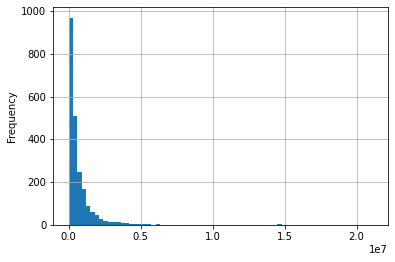

In [ ]:
data_set['Total'] = data_set['D_Marzo'] + data_set['D_Abril'] + data_set['D_Mayo'] + data_set['D_Junio'] + data_set['D_Julio'] + data_set['D_Agosto'] + data_set['D_Septiembre']
data_set['Total'].plot(kind='hist',bins=70, grid=True)
plt.show()

Se observa que la variable esta concentrada en un intervalo, por lo que se aplica su logaritmo:

In [ ]:
data_set['Ln_Total'] = np.log(data_set['Total']+1)

Graficando su logaritmo se puede ver que se asemeja a una distribución normal

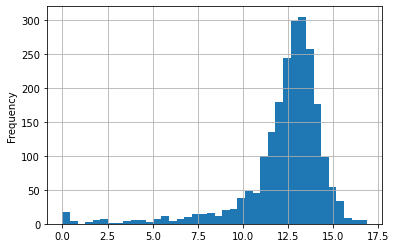

In [ ]:
data_set['Ln_Total'].plot(kind='hist',bins=40, grid=True )
plt.show()

Se elimina la variable "Total" y las variables deudas de todos los meses para quedarnos solo con el logaritmo total.

In [ ]:
del data_set['Total']
del data_set['D_Marzo']
del data_set['D_Abril']
del data_set['D_Mayo']
del data_set['D_Junio']
del data_set['D_Julio']
del data_set['D_Agosto']
del data_set['D_Septiembre']

## Agregación

Para la variable E_CIVIL se agrupa 'VIU' (viudo) con 'SEP' (separado), dado que se podría asumir que ambas categorías tienen un comportamiento similar.

In [ ]:
data_set['E_CIVIL'] = data_set['E_CIVIL'].replace('VIU', 'SEPA')
data_set['E_CIVIL'] = data_set['E_CIVIL'].replace('SEP', 'SEPA')

Además, se creará una nueva columna llamada "CAPITAL", que será de carácter binario:
*   1: Corresponde a Santiago
*   0: No corresponde a Santiago

La columna 'CIUDAD' será eliminada.

In [ ]:
def capital(string):
  if "SANTIAGO" in string:
    return 1
  else:
    return 0

In [ ]:
data_set["CAPITAL"] = data_set["CIUDAD"].apply(capital)
del data_set["CIUDAD"]
data_set

,GENERO,EDAD,NIV_EDUC,E_CIVIL,M_MOROSO,MONTO,SEGURO,FUGA,Ln_Total,CAPITAL
0,M,39.0,MED,CAS,2.0,2000000.0,NO,NOFUGA,13.089563,0
1,F,49.0,MED,SEPA,1.0,7500000.0,SI,NOFUGA,3.891820,1
2,M,39.0,TEC,CAS,1.0,8000000.0,NO,NOFUGA,13.359658,0
3,F,36.0,UNV,CAS,1.0,2600000.0,NO,NOFUGA,12.227457,1
4,M,44.0,TEC,CAS,1.0,6400000.0,NO,NOFUGA,11.365898,1
...,...,...,...,...,...,...,...,...,...,...
2289,F,43.0,TEC,SOL,3.0,1100000.0,SI,NOFUGA,13.386256,1
2290,M,54.0,TEC,SOL,1.0,1800000.0,NO,FUGA,14.054986,0
2291,M,51.0,UNV,SOL,1.0,4200000.0,NO,FUGA,13.502035,0
2292,M,42.0,UNV,CAS,2.0,4600000.0,NO,FUGA,13.408665,1


## Transformación de variables categóricas a binarias

A continuación, se transformarán todas las variables categóricas de la base de datos en dummies:

In [ ]:
data_set = pd.get_dummies(data_set, columns = ["SEGURO"], drop_first = True)
data_set = pd.get_dummies(data_set, columns = ["NIV_EDUC"], drop_first = True)
data_set = pd.get_dummies(data_set, columns = ["GENERO"], drop_first = True)
data_set = pd.get_dummies(data_set, columns = ["E_CIVIL"], drop_first = True)
data_set = pd.get_dummies(data_set, columns = ["FUGA"], drop_first = True)
data_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2227 entries, 0 to 2293
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   EDAD          2227 non-null   float64
 1   M_MOROSO      2227 non-null   float64
 2   MONTO         2227 non-null   float64
 3   Ln_Total      2227 non-null   float64
 4   CAPITAL       2227 non-null   int64  
 5   SEGURO_SI     2227 non-null   uint8  
 6   NIV_EDUC_MED  2227 non-null   uint8  
 7   NIV_EDUC_TEC  2227 non-null   uint8  
 8   NIV_EDUC_UNV  2227 non-null   uint8  
 9   GENERO_M      2227 non-null   uint8  
 10  E_CIVIL_SEPA  2227 non-null   uint8  
 11  E_CIVIL_SOL   2227 non-null   uint8  
 12  FUGA_NOFUGA   2227 non-null   uint8  
dtypes: float64(4), int64(1), uint8(8)
memory usage: 121.8 KB


## Discretización

**Discretizando la variable EDAD**

Hay que establecer un criterio para dividir las variables, en este caso se hará por cuantiles.

Primero se define los puntos de división a utilizar:



In [ ]:
cut_points = data_set['EDAD'].quantile([0, .2, .4, .6, .8, 1])

Ahora se discretiza la variable EDAD con los puntos definidos:

In [ ]:
EDAD_binned = pd.cut(data_set['EDAD'], bins =cut_points, include_lowest= True )
print(EDAD_binned)

0         (37.0, 42.0]
1         (46.0, 51.0]
2         (37.0, 42.0]
3       (22.999, 37.0]
4         (42.0, 46.0]
             ...      
2289      (42.0, 46.0]
2290      (51.0, 64.0]
2291      (46.0, 51.0]
2292      (37.0, 42.0]
2293      (46.0, 51.0]
Name: EDAD, Length: 2227, dtype: category
Categories (5, interval[float64]): [(22.999, 37.0] < (37.0, 42.0] < (42.0, 46.0] < (46.0, 51.0] <
                                    (51.0, 64.0]]


Entonces EDAD_binned será la variable EDAD discretizada.

# Selección de atributos

A modo de revisión general, se procede a calcular la desviación estándar de las variables:

In [ ]:
data_set.std()

EDAD            7.930457e+00
M_MOROSO        7.538850e-01
MONTO           2.286423e+06
Ln_Total        2.393507e+00
CAPITAL         4.890889e-01
SEGURO_SI       4.065432e-01
NIV_EDUC_MED    4.449185e-01
NIV_EDUC_TEC    4.621584e-01
NIV_EDUC_UNV    4.928168e-01
GENERO_M        4.887019e-01
E_CIVIL_SEPA    2.910564e-01
E_CIVIL_SOL     4.485345e-01
FUGA_NOFUGA     5.001110e-01
dtype: float64

Como se puede observar, no existe ninguna variable que posea una desviación estándar de cero, por lo que a priori no se puede eliminar ninguna.

**Cálculo la matriz de correlación entre todas las variables de la base de datos:**

                  EDAD  M_MOROSO  ...  E_CIVIL_SOL  FUGA_NOFUGA
EDAD          1.000000  0.089881  ...     0.056243     0.269991
M_MOROSO      0.089881  1.000000  ...     0.133368     0.322472
MONTO         0.154327  0.056641  ...     0.029446     0.107197
Ln_Total      0.055772  0.169108  ...     0.045737     0.135111
CAPITAL       0.024858  0.067864  ...     0.121503     0.186438
SEGURO_SI     0.103840  0.011138  ...     0.225013     0.092752
NIV_EDUC_MED  0.134588  0.025858  ...     0.087129     0.090492
NIV_EDUC_TEC  0.181889  0.150181  ...     0.240880     0.408609
NIV_EDUC_UNV  0.048781  0.167266  ...     0.145632     0.468510
GENERO_M      0.043933  0.233724  ...     0.232505     0.480686
E_CIVIL_SEPA  0.054189  0.041051  ...     0.199589     0.094953
E_CIVIL_SOL   0.056243  0.133368  ...     1.000000     0.225909
FUGA_NOFUGA   0.269991  0.322472  ...     0.225909     1.000000

[13 rows x 13 columns]


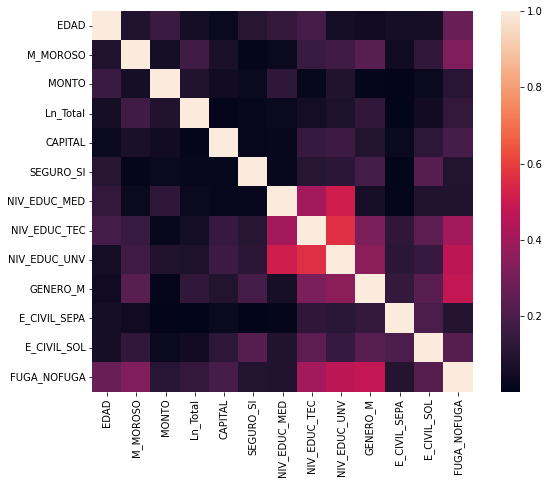

In [ ]:
corrmat = data_set.corr().abs()
f, ax = plt.subplots(figsize=(10, 7))
sn.heatmap(corrmat, square=True);
print(corrmat)

A pesar de que 'NIV_EDUC_UNV' y 'NIV_EDUC_TEC' dan indicios de una eventual redundancia al presentar una correlación cercana a 0.6, no existe una real certeza de que deba eliminarse alguna de las dos, al igual que en otros casos donde se observa una correlación mayor, por lo que se procederá a aplicar test chi-cuadrado, eliminando las que presenten menor relevancia.

**Selección de variables mas relevantes con test chi cuadrado**

Se seleccionarán las 9 variables que tengan el estadístico chi cuadrado mayor, siendo las restantes eliminadas al ser consideradas menos relevantes.

Primero se define como X las variables independientes y como Y la variable dependiente:

In [ ]:
X = data_set.loc[:, data_set.columns != 'FUGA_NOFUGA']
y = data_set.loc[:, data_set.columns == 'FUGA_NOFUGA']
X.shape

(2227, 12)

Ahora se aplica la función SelectKBest con el test chi cuadrado para determinar las variables mas relevantes:

In [ ]:
X_new = SelectKBest(chi2, k=9).fit(X, y)
x_final = X_new.fit_transform(X,y)
x_final.shape
print(x_final)

[[3.9e+01 2.0e+00 2.0e+06 ... 0.0e+00 1.0e+00 0.0e+00]
 [4.9e+01 1.0e+00 7.5e+06 ... 0.0e+00 0.0e+00 0.0e+00]
 [3.9e+01 1.0e+00 8.0e+06 ... 0.0e+00 1.0e+00 0.0e+00]
 ...
 [5.1e+01 1.0e+00 4.2e+06 ... 1.0e+00 1.0e+00 1.0e+00]
 [4.2e+01 2.0e+00 4.6e+06 ... 1.0e+00 1.0e+00 0.0e+00]
 [4.9e+01 1.0e+00 2.1e+06 ... 1.0e+00 1.0e+00 0.0e+00]]


Por último, se obtienen los nombres de las columnas seleccionadas:

In [ ]:
kbest = np.asarray(X.columns)[X_new.get_support()]
print(kbest)

['EDAD' 'M_MOROSO' 'MONTO' 'Ln_Total' 'CAPITAL' 'NIV_EDUC_TEC'
 'NIV_EDUC_UNV' 'GENERO_M' 'E_CIVIL_SOL']


Dadas las variables que se consideraron como las mas relevantes, se procede a eliminar todas las demás:

In [ ]:
del data_set["SEGURO_SI"]
del data_set["NIV_EDUC_MED"]
del data_set['E_CIVIL_SEPA']

Finalmente, se normalizan las variables que fueron consideradas relevantes para el proyecto, de modo de escalar los datos.

**Normalización**

In [ ]:
FUGA = data_set['FUGA_NOFUGA']
scaler = MinMaxScaler()
scaler_data = scaler.fit(data_set)
data_set_scaled = pd.DataFrame(scaler_data.transform(data_set), index=data_set.index, columns=data_set.columns)
data_set_scaled['FUGA_NOFUGA'] = FUGA
print(data_set_scaled)

          EDAD  M_MOROSO     MONTO  ...  GENERO_M  E_CIVIL_SOL  FUGA_NOFUGA
0     0.390244  0.666667  0.200000  ...       1.0          0.0            1
1     0.634146  0.333333  0.933333  ...       0.0          0.0            1
2     0.390244  0.333333  1.000000  ...       1.0          0.0            1
3     0.317073  0.333333  0.280000  ...       0.0          0.0            1
4     0.512195  0.333333  0.786667  ...       1.0          0.0            1
...        ...       ...       ...  ...       ...          ...          ...
2289  0.487805  1.000000  0.080000  ...       0.0          1.0            1
2290  0.756098  0.333333  0.173333  ...       1.0          1.0            0
2291  0.682927  0.333333  0.493333  ...       1.0          1.0            0
2292  0.463415  0.666667  0.546667  ...       1.0          0.0            0
2293  0.634146  0.333333  0.213333  ...       1.0          0.0            0

[2227 rows x 10 columns]


# Discusiones


El orden de relevancia de las variables según test chi-cuadrado es el siguiente:

1.   MONTO
2.   NIV_EDUC_UNV
3.   NIV_EDUC_TEC
4.   EDAD
5.   GENERO_M
6.   M_MOROSO
7.   E_CIVIL_SOL
8.   CAPITAL
9.   LN_TOTAL

Como se puede apreciar, la variable correspondiente al total de la deuda se encuentra en novena posición de relevancia. Dado que la problemática corresponde al ámbito financiero, se consideró que debía mantenerse como variable de interés, por lo que todas aquellas que quedasen en una posición inferior en relevancia podrían ser eliminadas.

En base a lo anterior, se puede concluir que si bien los métodos estadísticos ayuda a tomar decisiones referentes a cuáles variables son importantes en un modelo y cuáles no, de todas formas debe haber un análisis empírico, de manera de evitar eliminar variables que eventualmente pudiesen ser importantes considerar en un futuro. Lo anterior permitirá al modelo comportarse de mejor forma frente a un suceso de la vida real.









In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
result = srm.Logit(y_train, X_train).fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: inf
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            FUGA_NOFUGA   No. Observations:                 1558
Model:                          Logit   Df Residuals:                     1546
Method:                           MLE   Df Model:                           11
Date:                Wed, 01 Dec 2021   Pseudo R-squ.:                     inf
Time:                        22:46:20   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
EDAD            -0.0855      0.009     -9.119      0.000      -0.104      -0.067
M_MOROSO        -0.6252     

/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
